2.3 - Skapa två dataset  
Skapa en kopia av ditt dataframe. På ena dataframet:  
- ta bort följande features: ap_hi, ap_lo, height, weight, BMI  
- gör one-hot encoding på BMI-kategori, blodtryckskategori och kön  
På andra dataframet:  
- ta bort följande features: BMI-kategori, blodtryckskategori, height, weight  
- gör one-hot encoding på kön

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# loading df
df = pd.read_csv("heart_modified", index_col=0)

In [4]:
# creating two dataframes
df_1, df_2 = df, df

# dropping and creating dummies
df_1 = df_1.drop(["ap_hi", "ap_lo", "height", "weight" , "BMI"], axis=1)
df_1 = pd.get_dummies(df_1, columns=["BMI-class", "Blood-pressure", "gender"], drop_first=False)

df_2 = df_2.drop(["BMI-class", "Blood-pressure", "height", "weight"], axis=1)
df_2 = pd.get_dummies(df_2, columns=["gender"], drop_first=False)

# checking that columns are correct
df_1.columns, df_2.columns


(Index(['id', 'age', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio',
        'age_years', 'BMI-class_Normal', 'BMI-class_Obese (class 1)',
        'BMI-class_Obese (class 2)', 'BMI-class_Obese (class 3)',
        'BMI-class_Overweight', 'BMI-class_Underweight',
        'Blood-pressure_Elevated', 'Blood-pressure_Healthy',
        'Blood-pressure_Hypertension crisis',
        'Blood-pressure_Stage 1 hypertension',
        'Blood-pressure_Stage 2 hypertension', 'gender_1', 'gender_2'],
       dtype='object'),
 Index(['id', 'age', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco',
        'active', 'cardio', 'age_years', 'BMI', 'gender_1', 'gender_2'],
       dtype='object'))

2.4 - Välja modell  
Välj 3-5 maskininlärningsmodeller, gärna så olika som möjligt. För varje dataset som vi skapade i uppgift 2.3  
gör följande:  
- train|validation|test split
- skala datasetet med feature standardization och normalization (de görs inte samtidigt, utan i olika  
- omgångar)  
- definiera hyperparametrar (param_grids) att testa för varje modell  
- använda GridSearchCV() och välja lämplig evalueringsmetric  
- gör prediction på valideringsdata  
- beräkna och spara evaluation score för ditt valda metric  
- checka bästa parametrarna för respektive modell  
- Vilket dataset väljer du och vilken modell väljer du? Använd den modellen du valt och träna på all data  
- förutom testdatan.  

In [5]:
from sklearn.model_selection import train_test_split
X_1 = df_1.drop("cardio", axis=1)
y_1 = df_1["cardio"]

# train|val|test split on both dataframes
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42) 
X_1_train, X_1_val, y_1_train, y_1_val = train_test_split(X_1_train, y_1_train, test_size=0.2, random_state=42) 


X_2 = df_2.drop("cardio", axis=1)
y_2 = df_2["cardio"]

X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42) 
X_2_train, X_2_val, y_2_train, y_2_val = train_test_split(X_2_train, y_2_train, test_size=0.2, random_state=42) 


In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# scaling and using PCA on both dataframes to do elbow plot

scaled_X_1_train = standard_scaler.fit_transform(X_1_train)
scaled_X_1_val = standard_scaler.transform(X_1_val)

pca_1 = PCA(n_components=X_1_train.shape[1])
pca_transformation = pca_1.fit_transform(scaled_X_1_train)
pca_1.explained_variance_ratio_

scaled_X_2_train = standard_scaler.fit_transform(X_2_train)
scaled_X_2_val = standard_scaler.transform(X_2_val)

pca_2 = PCA(n_components=X_2_train.shape[1])
pca_transformation = pca_2.fit_transform(scaled_X_2_train)
pca_2.explained_variance_ratio_


array([1.90757548e-01, 1.78951065e-01, 1.19577528e-01, 9.90522760e-02,
       8.32403416e-02, 7.73003026e-02, 7.60045568e-02, 6.16765863e-02,
       4.85424385e-02, 4.16859454e-02, 2.32114123e-02, 6.10398567e-31,
       8.60856985e-32])

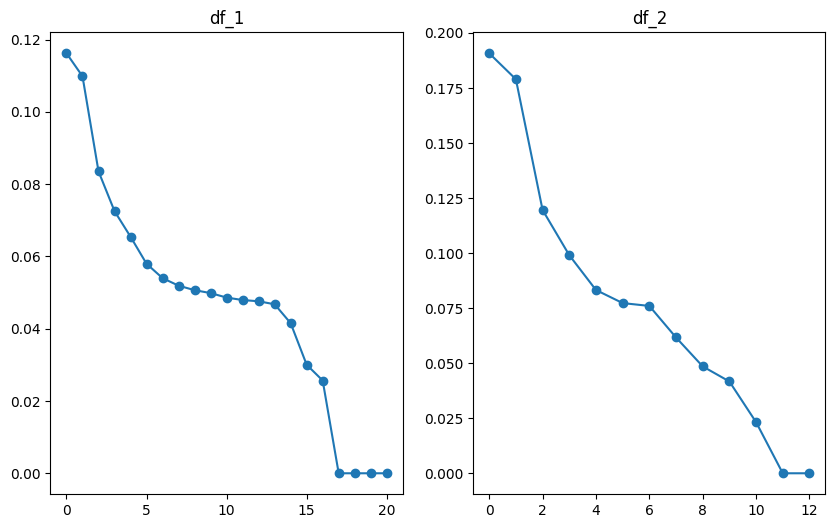

In [7]:
# making elbow plots

fig, axes = plt.subplots(1, 2, figsize=(10,6))

axes[0].plot(range(0, X_1_train.shape[1]), pca_1.explained_variance_ratio_, "-o")
axes[0].set_title("df_1")

axes[1].plot(range(0, X_2_train.shape[1]), pca_2.explained_variance_ratio_, "-o")
axes[1].set_title("df_2")
plt.savefig("images/Elbow plot PCA")

# we note the values 17 and 11

In [ ]:


from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Making pipelines for a few different models
# Trhough trial and error i found that df_2 with minmaxscaling gave the best results
# Since i chose df_2 i use PCA(11)

pipe_KNN = Pipeline(
    [
        ("scaler", minmax_scaler),
        ("dimension_reduction", PCA(11)),
        ("knn", KNeighborsClassifier()),
    ]
)
pipe_logistic = Pipeline(
    [
        ("scaler", minmax_scaler),
        ("dimension_reduction", PCA(11)),
        (
            "log",
            LogisticRegression(
                penalty="elasticnet", solver="saga", multi_class="auto", max_iter=10000
            ),
        ),
    ]
)
pipe_SVC = Pipeline(
    [
        ("scaler", minmax_scaler),
        ("dimension_reduction", PCA(11)),
        ("SVC", LinearSVC()),
    ]
)
pipe_randomforest = Pipeline(
    [
        ("scaler", minmax_scaler),
        ("dimension_reduction", PCA(11)),
        ("randomforest", RandomForestClassifier()),
    ]
)

# creating paramgrids for Gridsearch. These have been tuned multipel times

param_grid_KNN = {"knn__n_neighbors": [39, 40]}
param_grid_logistic = {"log__l1_ratio": np.linspace(0.73, 0.74, 5)}
param_grid_SVC = {"SVC__C": [0.05, 0.1, 0.2]}
param_grid_randomforest = {
    "randomforest__n_estimators": [110, 120, 130],
    "randomforest__max_depth": [10, 11],
}

# Creating Gridsearch instances

classifier_KNN = GridSearchCV(
    estimator=pipe_KNN,
    param_grid=param_grid_KNN,
    cv=5,
    scoring="accuracy",
)
classifier_logistic = GridSearchCV(
    estimator=pipe_logistic,
    param_grid=param_grid_logistic,
    cv=5,
    scoring="accuracy",
)
classifier_SVC = GridSearchCV(
    estimator=pipe_SVC,
    param_grid=param_grid_SVC,
    cv=5,
    scoring="accuracy",
)
classifier_randomforest = GridSearchCV(
    estimator=pipe_randomforest,
    param_grid=param_grid_randomforest,
    cv=5,
    scoring="accuracy",
)


In [ ]:
# training models and noting time difference with or without PCA

classifier_KNN.fit(X_2_train, y_2_train)
# 3m 6s without PCA - 2m 40s with PCA(10)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('dimension_reduction',
                                        PCA(n_components=11)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [39, 40]}, scoring='accuracy')

In [ ]:
classifier_logistic.fit(X_2_train, y_2_train)
# 7m 30s without PCA - 22s with PCA(10)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('dimension_reduction',
                                        PCA(n_components=11)),
                                       ('log',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             param_grid={'log__l1_ratio': array([0.73  , 0.7325, 0.735 , 0.7375, 0.74  ])},
             scoring='accuracy')

In [ ]:
classifier_SVC.fit(X_2_train, y_2_train)
# 1m 30s wihout PCA - 25s with PCA(10)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('dimension_reduction',
                                        PCA(n_components=11)),
                                       ('SVC', LinearSVC())]),
             param_grid={'SVC__C': [0.05, 0.1, 0.2]}, scoring='accuracy')

In [ ]:
classifier_randomforest.fit(X_2_train, y_2_train)
# 3m 30s with PC(10)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('dimension_reduction',
                                        PCA(n_components=11)),
                                       ('randomforest',
                                        RandomForestClassifier())]),
             param_grid={'randomforest__max_depth': [10, 11],
                         'randomforest__n_estimators': [110, 120, 130]},
             scoring='accuracy')

In [ ]:
# Checking best parameters

#classifier_logistic.best_estimator_.get_params()
#classifier_KNN.best_estimator_.get_params()
#classifier_SVC.best_estimator_.get_params()
classifier_randomforest.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('dimension_reduction', PCA(n_components=11)),
  ('randomforest', RandomForestClassifier(max_depth=10, n_estimators=110))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'dimension_reduction': PCA(n_components=11),
 'randomforest': RandomForestClassifier(max_depth=10, n_estimators=110),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'dimension_reduction__copy': True,
 'dimension_reduction__iterated_power': 'auto',
 'dimension_reduction__n_components': 11,
 'dimension_reduction__n_oversamples': 10,
 'dimension_reduction__power_iteration_normalizer': 'auto',
 'dimension_reduction__random_state': None,
 'dimension_reduction__svd_solver': 'auto',
 'dimension_reduction__tol': 0.0,
 'dimension_reduction__whiten': False,
 'randomforest__bootstrap': True,
 'randomforest__ccp_alpha': 0.0,
 'randomforest__class_weight': None,
 'randomforest__criterion': 'gini',
 'randomforest__max_depth': 10,
 'randomfo

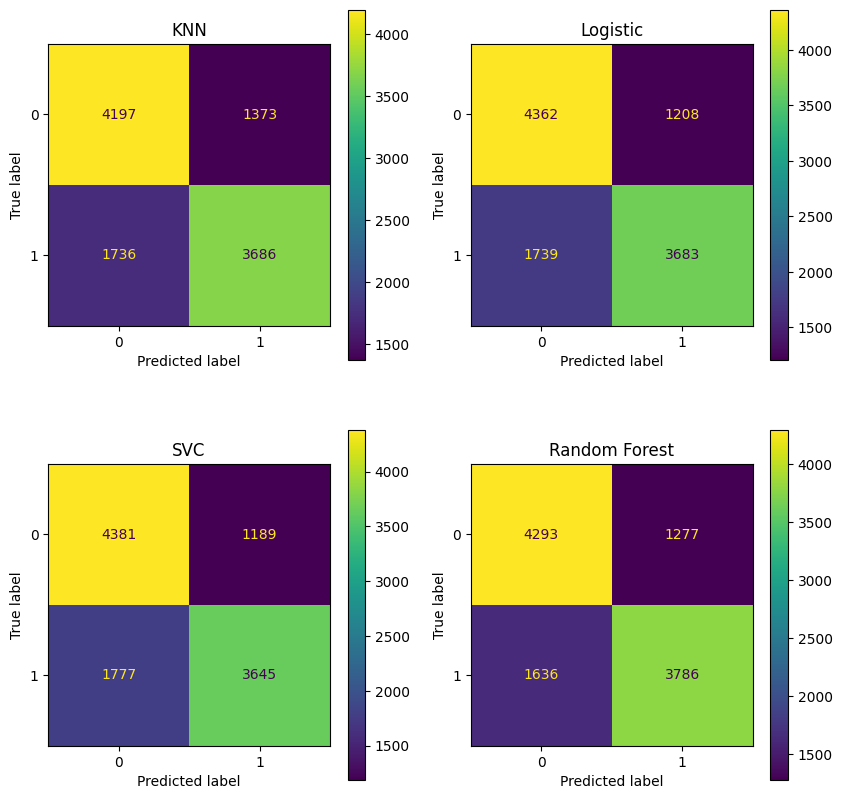

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Making plots to evaluate the different models

fig, axes = plt.subplots(2, 2, figsize=(10,10))

y_pred_KNN = classifier_KNN.predict(X_2_val)
y_pred_logistic = classifier_logistic.predict(X_2_val)
y_pred_SVC = classifier_SVC.predict(X_2_val)
y_pred_randomforest = classifier_randomforest.predict(X_2_val)

cm_KNN = confusion_matrix(y_2_val, y_pred_KNN)
cm_log = confusion_matrix(y_2_val, y_pred_logistic)
cm_SVC = confusion_matrix(y_2_val, y_pred_SVC)
cm_randomforest = confusion_matrix(y_2_val, y_pred_randomforest)

ConfusionMatrixDisplay(cm_KNN).plot(ax = axes[0][0])
axes[0][0].set_title("KNN")
ConfusionMatrixDisplay(cm_log).plot(ax = axes[0][1])
axes[0][1].set_title("Logistic")
ConfusionMatrixDisplay(cm_SVC).plot(ax = axes[1][0])
axes[1][0].set_title("SVC")
ConfusionMatrixDisplay(cm_randomforest).plot(ax = axes[1][1])
axes[1][1].set_title("Random Forest")
    
plt.savefig("images/Confusion_matrices_PCA_set2_minmax")

In [ ]:
# Checking score of random forest which had the lowest False negative
print(classification_report(y_2_val, y_pred_randomforest))

              precision    recall  f1-score   support

           0       0.72      0.77      0.75      5570
           1       0.75      0.70      0.72      5422

    accuracy                           0.73     10992
   macro avg       0.74      0.73      0.73     10992
weighted avg       0.74      0.73      0.73     10992



In [ ]:
# # Scaling 

# scaled_X_2_train = minmax_scaler.fit_transform(X_2_train)
# scaled_X_2_val = minmax_scaler.transform(X_2_val)

# pca = PCA(n_components=10)
# scaled_pca_X_2_train = pca.fit_transform(scaled_X_2_train)
# scaled_pca_X_2_val = pca.fit_transform(scaled_X_2_val)



2.5 Ensemble  
Använd VotingClassifier() på datasetet som du valt och lägg in de bästa parametrarna för respektive  
modell.

In [ ]:
from sklearn.ensemble import VotingClassifier

# Making a voting classifier from the three models that performed best

vote_clf = VotingClassifier([
    ("logistic", LogisticRegression(l1_ratio=0.735, penalty="elasticnet", solver="saga", multi_class="auto", max_iter=10000)),
    ("knn", KNeighborsClassifier(n_neighbors=39)),
    ("random_forest", RandomForestClassifier(n_estimators=110, max_depth=11)),
], voting = "soft")

pipe = Pipeline(
    [
        ("scaler", minmax_scaler),
        ("dimension_reduction", PCA(11)),
        ("clf", vote_clf),
    ]
)

pipe.fit(X_2_train, y_2_train)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('dimension_reduction', PCA(n_components=11)),
                ('clf',
                 VotingClassifier(estimators=[('logistic',
                                               LogisticRegression(l1_ratio=0.735,
                                                                  max_iter=10000,
                                                                  penalty='elasticnet',
                                                                  solver='saga')),
                                              ('knn',
                                               KNeighborsClassifier(n_neighbors=39)),
                                              ('random_forest',
                                               RandomForestClassifier(max_depth=11,
                                                                      n_estimators=110))],
                                  voting='soft'))])

2.6 Evalueringar
Gör confusion matrices och classification reports för 2.4 och 2.5.

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      5570
           1       0.75      0.69      0.72      5422

    accuracy                           0.73     10992
   macro avg       0.74      0.73      0.73     10992
weighted avg       0.74      0.73      0.73     10992



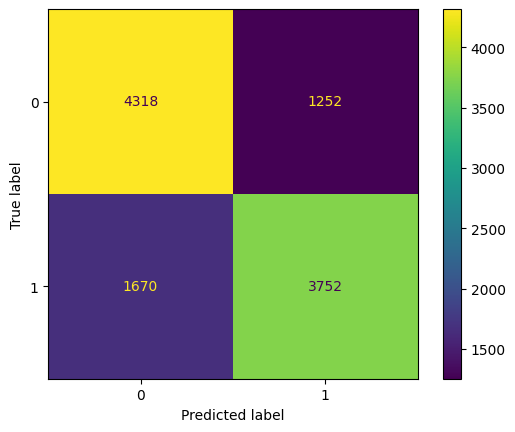

In [ ]:
# Confusion Matrix and classification reports for 2.4 is made above
# Doing confusion Matrx and Classification report on Voting classifier here

y_pred = pipe.predict(X_2_val)

print(classification_report(y_2_val, y_pred))
cm = confusion_matrix(y_2_val, y_pred)
ConfusionMatrixDisplay(cm).plot()

2.7 "Deploy" - spara modell  
Börja med att plocka ut 100 slumpmässigt valda rader från ditt dataset. Exportera dessa 100 samples i  
test_samples.csv. Därefter tar du den bästa modellen och träna på all data vi har förutom de 100  
datapunkterna du plockade ut. Spara därefter modellen i en .pkl-fil med hjälp av joblib.dump(). För  
modellen kan du behöva använda argumentet compress för att komprimera om filstorleken för stor.  

In [ ]:
# Dropping 100 random samples

np.random.seed(42)
drop_indices = np.random.choice(df_2.index, 100, replace=True)

df_2_subset = df_2.drop(drop_indices)
df_2_test_samples = df_2.iloc[drop_indices]
df_2_test_samples.to_csv("test_samples.csv")

In [ ]:
# Defining X and y on new dataset

X = df_2_subset.drop("cardio", axis=1)
y = df_2_subset["cardio"]


In [ ]:
import joblib

# Saving pipeline with model to file

pipe.fit(X, y)

joblib.dump(pipe, "pipe.pkl")


['pipe.pkl']